In [14]:
# class that inherits from property based test
import numpy as np
import csv
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from sympy.printing.pretty.pretty_symbology import line_width

from qucheck.property import Property
from qucheck.input_generators import RandomState
from qucheck.test_runner import TestRunner

In [15]:
def read_stored_data(algorithm_name):
    inputs = [100, 50, 25]
    shots = [2000, 1000, 500]
    for input_val in inputs:
        for measurements in shots:
            print(f"number of inputs: {input_val}, number of measurements: {measurements}")
            filename_no_sub = f"mutation_test_results/{algorithm_name}/{algorithm_name}_{input_val}_{measurements}_mt_results.csv"
            filename_sub = f"mutation_test_results/{algorithm_name}/{algorithm_name}_{input_val}_{measurements}_mt_results_sub.csv"
            print("no sub")
            with open(filename_no_sub, 'r') as csvfile:
                csvreader = csv.reader(csvfile)
                for line in csvreader:
                    print(line)
            print("sub")
            with open(filename_sub, 'r') as csvfile2:
                csvreader = csv.reader(csvfile2)
                for line in csvreader:
                    print(line)

read_stored_data("quantum_teleportation")

number of inputs: 100, number of measurements: 2000
no sub
['Mutant Name', 'Result', 'Number of Circuits Executed', 'Number of Unique Failed Properties', 'Number of Failed Properties', 'Unique Failed Properties', 'Time Taken']
['quantum_teleportation_m0', 'Fail', '1203', '3', '298', 'Inq0EqualOutq2 & NotTeleportedPlus & UnitaryBeforeAndAfterTeleport', '8.598567724227905']
['quantum_teleportation_m1', 'Fail', '1203', '3', '297', 'Inq0EqualOutq2 & NotTeleportedPlus & UnitaryBeforeAndAfterTeleport', '8.248708963394165']
['quantum_teleportation_m2', 'Fail', '1203', '3', '297', 'Inq0EqualOutq2 & NotTeleportedPlus & UnitaryBeforeAndAfterTeleport', '8.282053470611572']
['quantum_teleportation_m3', 'Fail', '1203', '3', '299', 'Inq0EqualOutq2 & NotTeleportedPlus & UnitaryBeforeAndAfterTeleport', '8.228544473648071']
['quantum_teleportation_m4', 'Fail', '1203', '3', '296', 'Inq0EqualOutq2 & NotTeleportedPlus & UnitaryBeforeAndAfterTeleport', '8.442162990570068']
['quantum_teleportation_m5', 'Fai

In [16]:
# plot number of failures for sub and no sub for each m 
# then a separate plot for each em
def read_stored_data_to_dataframe(algorithm_name, do_subsample=True):
    inputs = [100, 50, 25]
    shots = [2000, 1000, 500]
    data_df = pd.DataFrame(columns=["mutant_name", "inputs", "shots", "subsample", "result", "failures", "failures_percentage", "time"])
    for input_val in inputs:
        for measurements in shots:
            filename_no_sub = f"mutation_test_results/{algorithm_name}/{algorithm_name}_{input_val}_{measurements}_mt_results.csv"
            filename_sub = f"mutation_test_results/{algorithm_name}/{algorithm_name}_{input_val}_{measurements}_mt_results_sub.csv"
            with open(filename_no_sub, 'r') as csvfile:
                csvreader = csv.reader(csvfile)
                for i, line in enumerate(csvreader):
                    if i != 0:
                        data_df.loc[len(data_df.index)] = [line[0], input_val, measurements, False, line[1], int(line[4]), int(line[4])/(input_val*3), float(line[6])]
            if do_subsample:
                with open(filename_sub, 'r') as csvfile2:
                    csvreader = csv.reader(csvfile2)
                    for i, line in enumerate(csvreader):
                        if i != 0:
                            data_df.loc[len(data_df.index)] = [line[0], input_val, measurements, True, line[1], int(line[4]), int(line[4])/(input_val*3), float(line[6])]
    return data_df

qt_df = read_stored_data_to_dataframe("quantum_teleportation")
dj_df = read_stored_data_to_dataframe("deutsch_jozsa")
qft_df = read_stored_data_to_dataframe("quantum_fourier_transform")
gr_df = read_stored_data_to_dataframe("grovers_algorithm", do_subsample=False)
phase_df = read_stored_data_to_dataframe("quantum_phase_estimation", do_subsample=False)

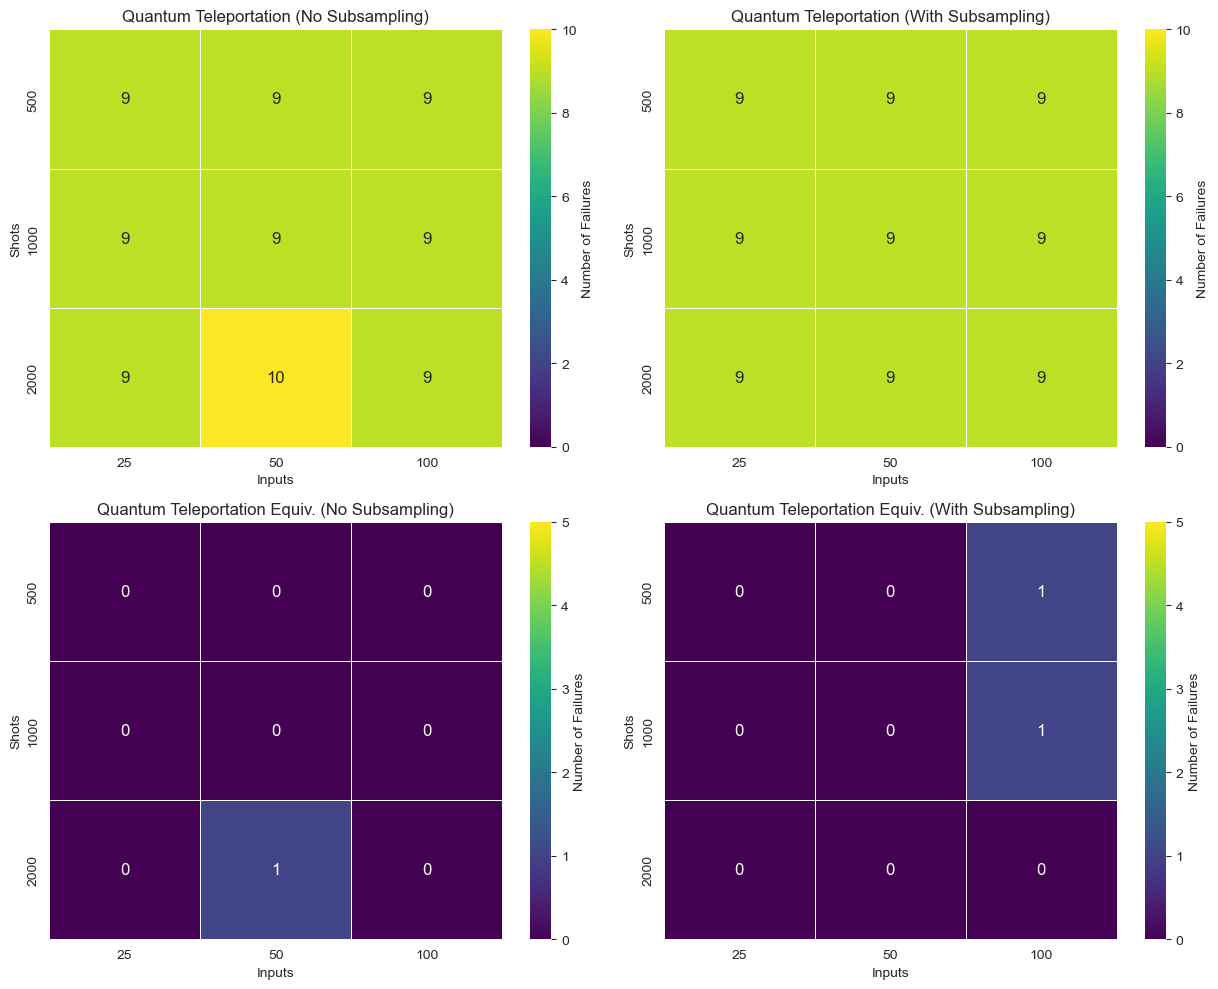

In [10]:
def plot_failures(df, algorithm_name, do_subsample=True):
    df_non_equivalent = df[df['mutant_name'].str.contains('_m')]
    df_equivalent = df[df['mutant_name'].str.contains('_em')]
    
    if do_subsample:
        df_non_equivalent_sub = df_non_equivalent[df_non_equivalent['subsample'] == True]
        df_equivalent_sub = df_equivalent[df_equivalent['subsample'] == True]
        failure_rate_sub = df_non_equivalent_sub.groupby(['shots', 'inputs'])['result'].apply(lambda x: (x == 'Fail').sum()).unstack()
        pass_rate_sub = df_equivalent_sub.groupby(['shots', 'inputs'])['result'].apply(lambda x: (x == 'Fail').sum()).unstack()
    
    df_non_equivalent_no_sub = df_non_equivalent[df_non_equivalent['subsample'] == False]
    df_equivalent_no_sub = df_equivalent[df_equivalent['subsample'] == False]
    failure_rate_no_sub = df_non_equivalent_no_sub.groupby(['shots', 'inputs'])['result'].apply(lambda x: (x == 'Fail').sum()).unstack()
    pass_rate_no_sub = df_equivalent_no_sub.groupby(['shots', 'inputs'])['result'].apply(lambda x: (x == 'Fail').sum()).unstack()

    
    # Create subplots
    if do_subsample:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.5, 10))
    else:
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 10))

    # viridis or magma
    palette = sns.color_palette("viridis", as_cmap=True)

    # Plot heatmap for non-equivalent mutants without subsampling
    sns.heatmap(failure_rate_no_sub, annot=True, cmap=palette, ax=ax1, fmt='d', linewidth=0.5, vmin=0, vmax=10, cbar_kws={'label': 'Number of Failures'}, annot_kws={"size": 12})
    ax1.set_title(f'{algorithm_name} (No Subsampling)')
    ax1.set_xlabel('Inputs')
    ax1.set_ylabel('Shots')

    # Plot heatmap for non-equivalent mutants with subsampling
    if do_subsample:
        sns.heatmap(failure_rate_sub, annot=True, cmap=palette, ax=ax2, fmt='d', linewidth=0.5, vmin=0, vmax=10, cbar_kws={'label': 'Number of Failures'}, annot_kws={"size": 12})
        ax2.set_title(f'{algorithm_name} (With Subsampling)')
        ax2.set_xlabel('Inputs')
        ax2.set_ylabel('Shots')

    # Plot heatmap for equivalent mutants without subsampling
    sns.heatmap(pass_rate_no_sub, annot=True, cmap=palette, ax=ax3, fmt='d', linewidth=0.5, vmin=0, vmax=5, cbar_kws={'label': 'Number of Failures'}, annot_kws={"size": 12})
    ax3.set_title(f'{algorithm_name} Equiv. (No Subsampling)')
    ax3.set_xlabel('Inputs')
    ax3.set_ylabel('Shots')

    # Plot heatmap for equivalent mutants with subsampling
    if do_subsample:
        sns.heatmap(pass_rate_sub, annot=True, cmap=palette, ax=ax4, fmt='d', linewidth=0.5, vmin=0, vmax=5, cbar_kws={'label': 'Number of Failures'}, annot_kws={"size": 12})
        ax4.set_title(f'{algorithm_name} Equiv. (With Subsampling)')
        ax4.set_xlabel('Inputs')
        ax4.set_ylabel('Shots')

    plt.tight_layout()
    plt.show()
    
    
plot_failures(qt_df, "Quantum Teleportation", do_subsample=True)

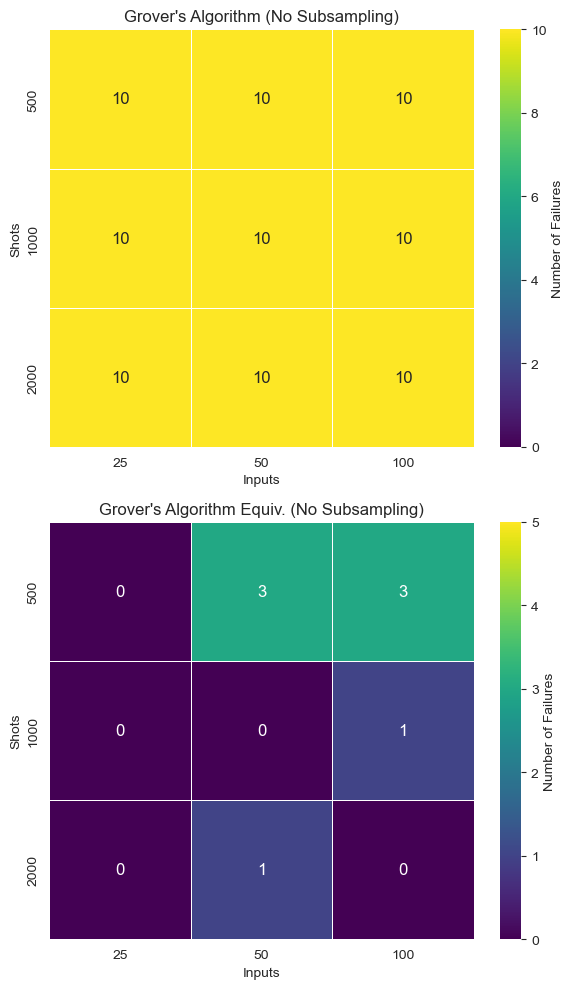

In [11]:
plot_failures(gr_df, "Grover's Algorithm", do_subsample=False)

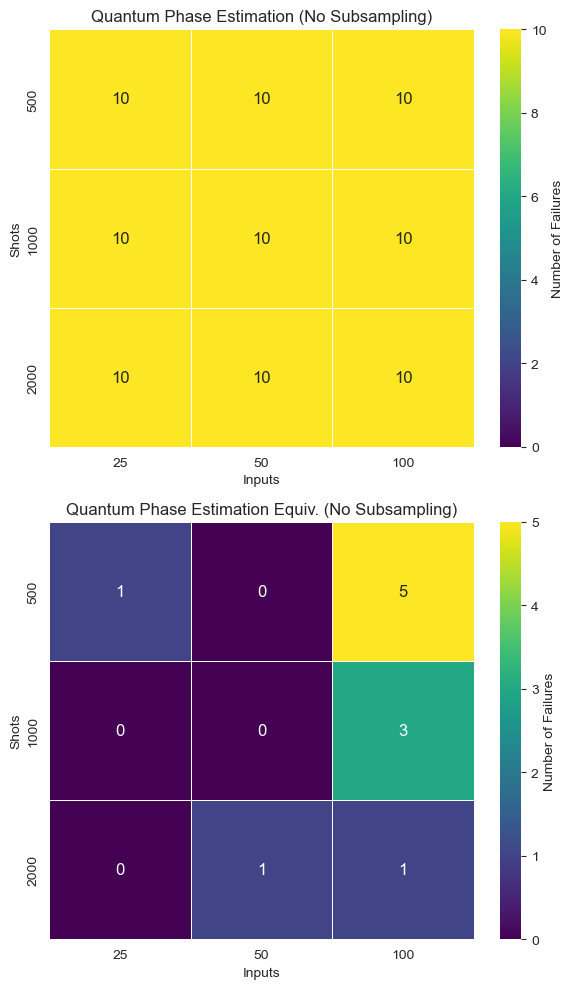

In [12]:
plot_failures(phase_df, "Quantum Phase Estimation", do_subsample=False)

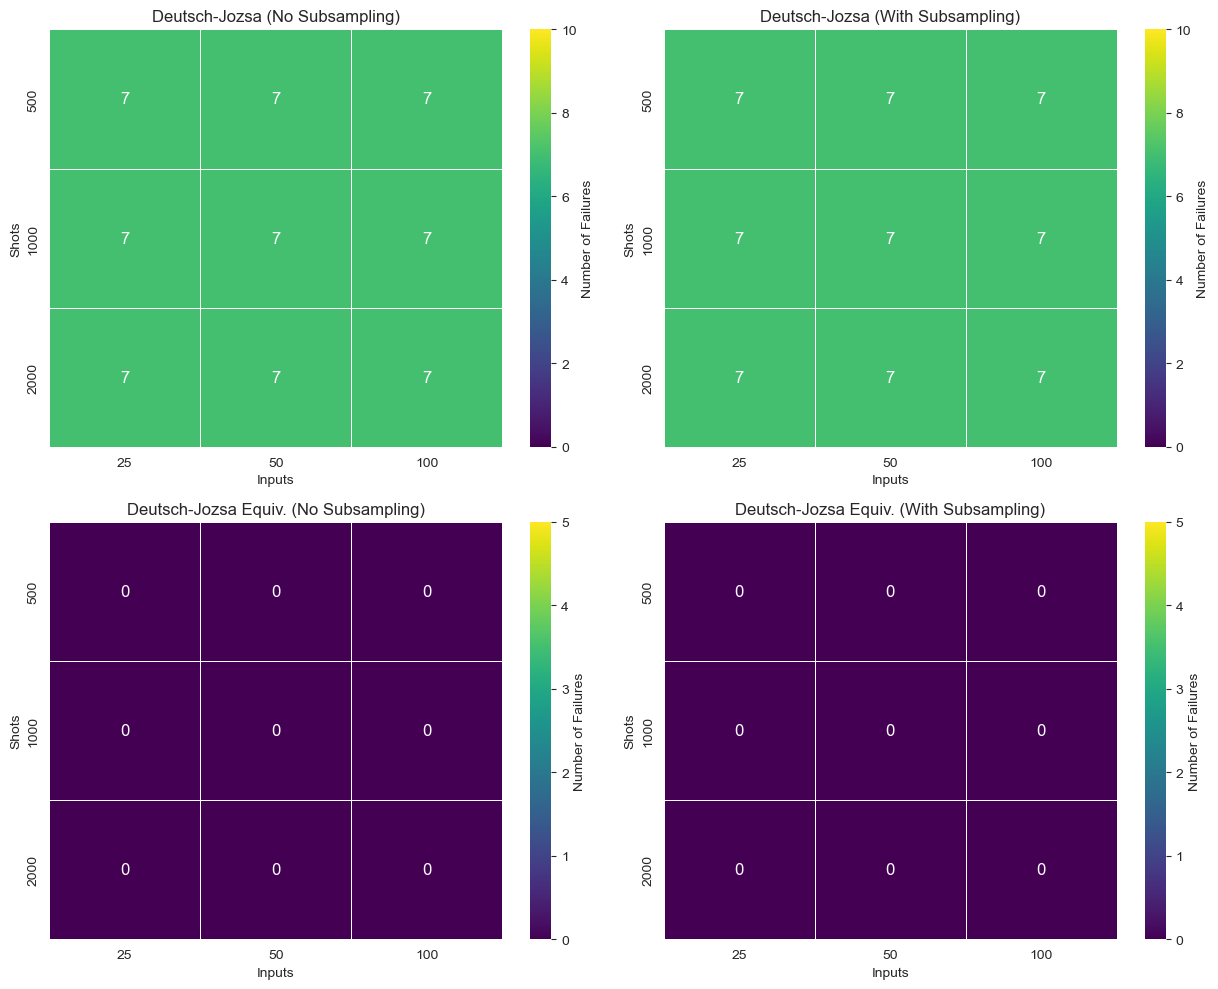

In [6]:
plot_failures(dj_df, "Deutsch-Jozsa")

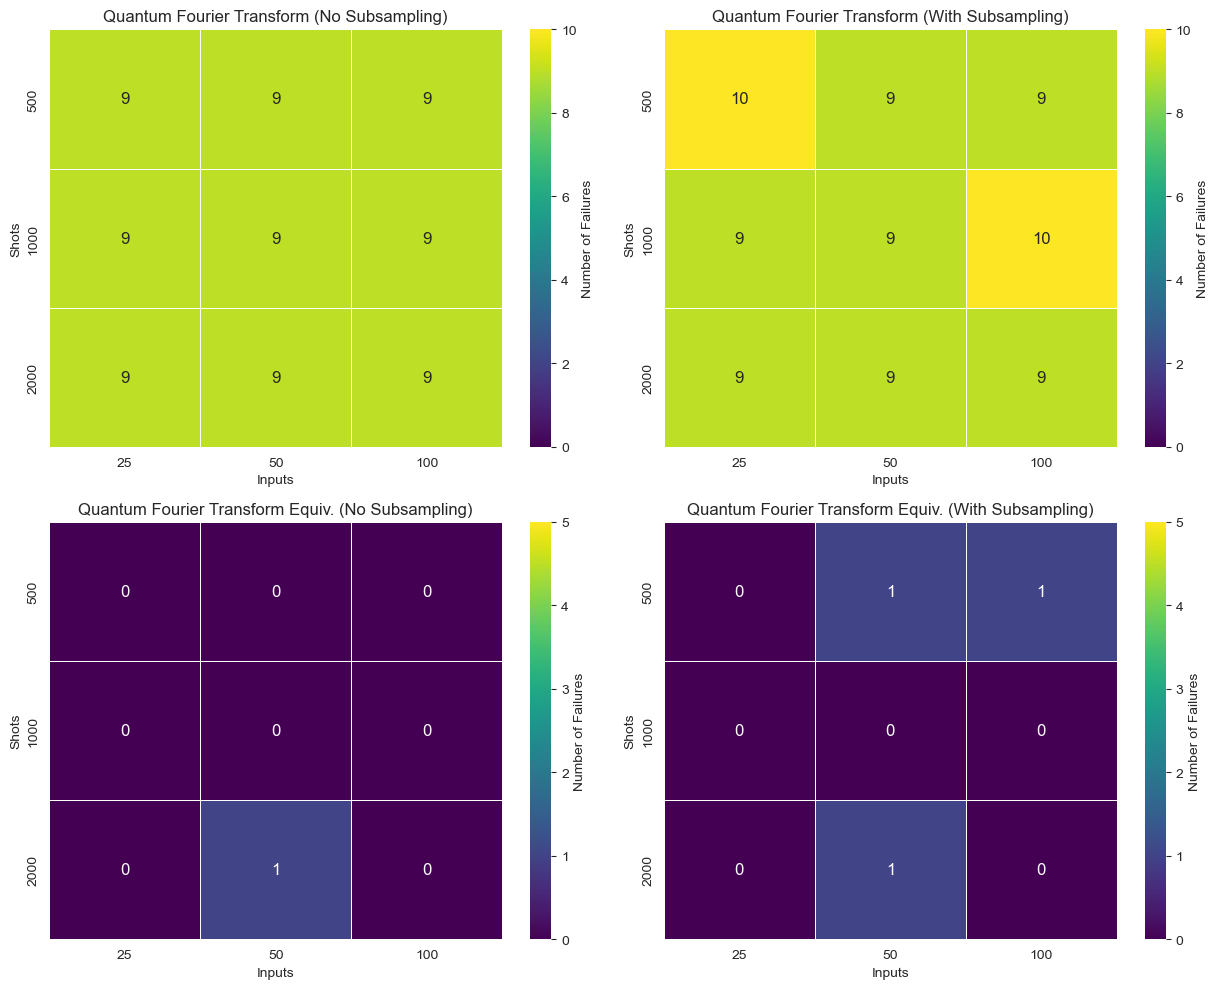

In [7]:
plot_failures(qft_df, "Quantum Fourier Transform")

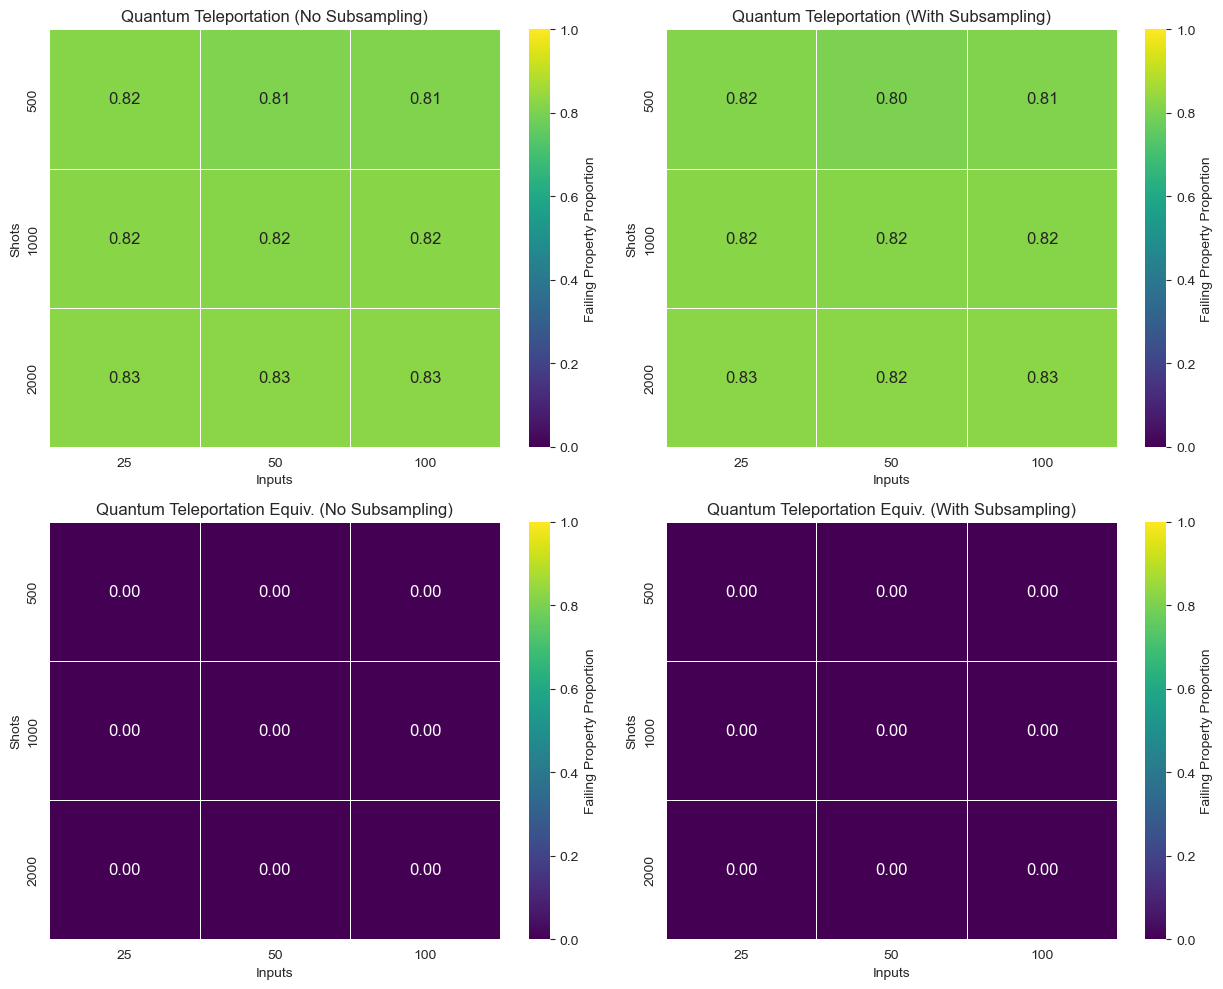

In [15]:
def plot_percentage_failures(df, algorithm_name, do_subsample=True):
    df_non_equivalent = df[df['mutant_name'].str.contains('_m')]
    df_equivalent = df[df['mutant_name'].str.contains('_em')]
    
    if do_subsample:
        df_non_equivalent_sub = df_non_equivalent[df_non_equivalent['subsample'] == True]
        df_equivalent_sub = df_equivalent[df_equivalent['subsample'] == True]
        failure_rate_sub = df_non_equivalent_sub.groupby(['shots', 'inputs'])['failures_percentage'].apply(lambda x: x.sum()/10).unstack()
        pass_rate_sub = df_equivalent_sub.groupby(['shots', 'inputs'])['failures_percentage'].apply(lambda x: x.sum()/5).unstack()
    
    df_non_equivalent_no_sub = df_non_equivalent[df_non_equivalent['subsample'] == False]
    df_equivalent_no_sub = df_equivalent[df_equivalent['subsample'] == False]
    failure_rate_no_sub = df_non_equivalent_no_sub.groupby(['shots', 'inputs'])['failures_percentage'].apply(lambda x: x.sum()/10).unstack()
    pass_rate_no_sub = df_equivalent_no_sub.groupby(['shots', 'inputs'])['failures_percentage'].apply(lambda x: x.sum()/5).unstack()

    
    # Create subplots
    if do_subsample:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.5, 10))
    else:
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 10))

    # viridis or magma
    palette = sns.color_palette("viridis", as_cmap=True)

    # Plot heatmap for non-equivalent mutants without subsampling
    sns.heatmap(failure_rate_no_sub, annot=True, cmap=palette, ax=ax1, fmt='.2f', linewidth=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Failing Property Proportion'}, annot_kws={"size": 12})
    ax1.set_title(f'{algorithm_name} (No Subsampling)')
    ax1.set_xlabel('Inputs')
    ax1.set_ylabel('Shots')

    # Plot heatmap for non-equivalent mutants with subsampling
    if do_subsample:
        sns.heatmap(failure_rate_sub, annot=True, cmap=palette, ax=ax2, fmt='.2f', linewidth=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Failing Property Proportion'}, annot_kws={"size": 12})
        ax2.set_title(f'{algorithm_name} (With Subsampling)')
        ax2.set_xlabel('Inputs')
        ax2.set_ylabel('Shots')

    # Plot heatmap for equivalent mutants without subsampling
    sns.heatmap(pass_rate_no_sub, annot=True, cmap=palette, ax=ax3, fmt='.2f', linewidth=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Failing Property Proportion'}, annot_kws={"size": 12})
    ax3.set_title(f'{algorithm_name} Equiv. (No Subsampling)')
    ax3.set_xlabel('Inputs')
    ax3.set_ylabel('Shots')

    # Plot heatmap for equivalent mutants with subsampling
    if do_subsample:
        sns.heatmap(pass_rate_sub, annot=True, cmap=palette, ax=ax4, fmt='.2f', linewidth=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Failing Property Proportion'}, annot_kws={"size": 12})
        ax4.set_title(f'{algorithm_name} Equiv. (With Subsampling)')
        ax4.set_xlabel('Inputs')
        ax4.set_ylabel('Shots')

    plt.tight_layout()
    plt.show()

plot_percentage_failures(qt_df, "Quantum Teleportation", do_subsample=True)

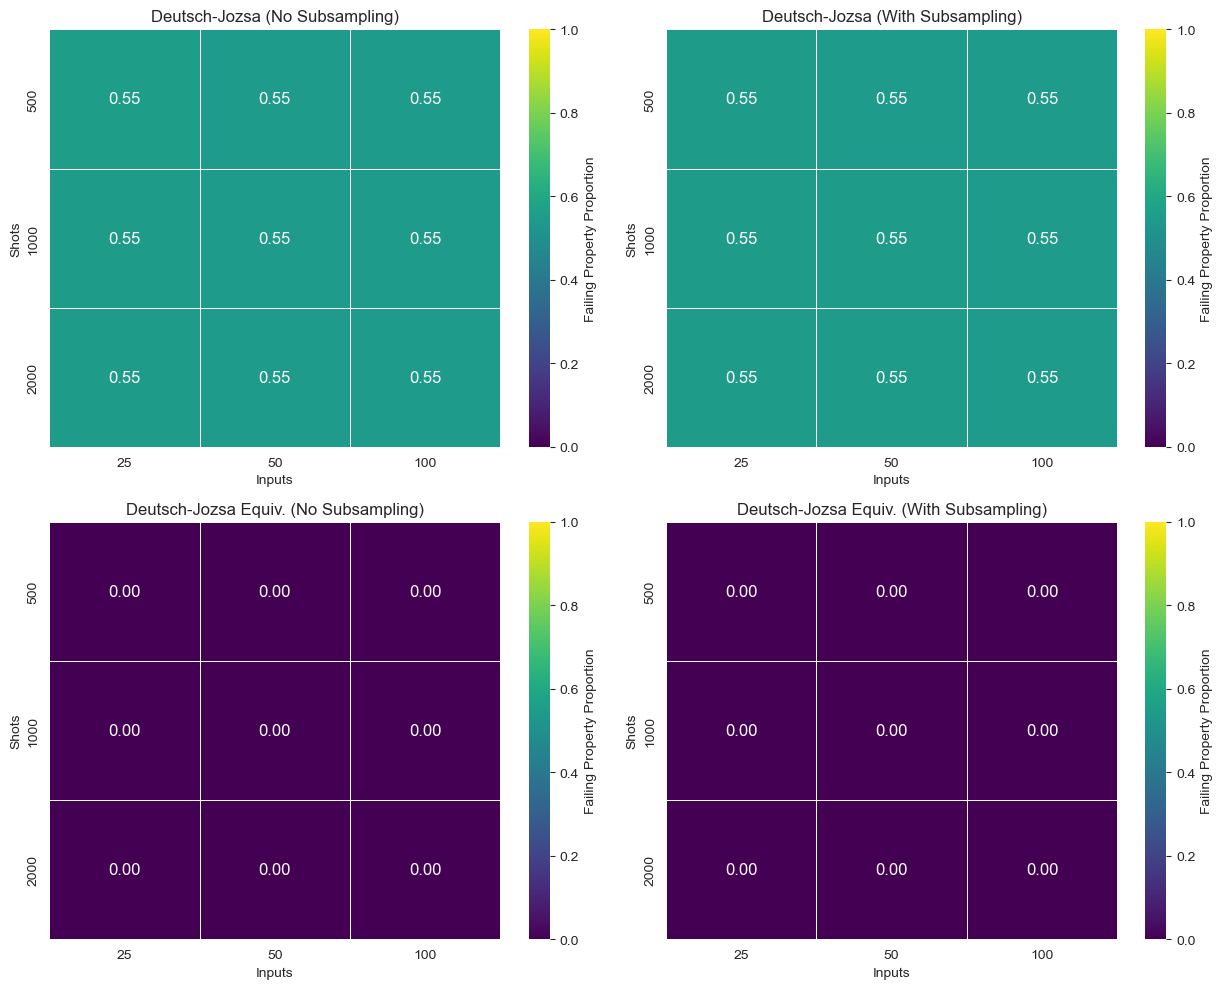

In [9]:
plot_percentage_failures(dj_df, "Deutsch-Jozsa")

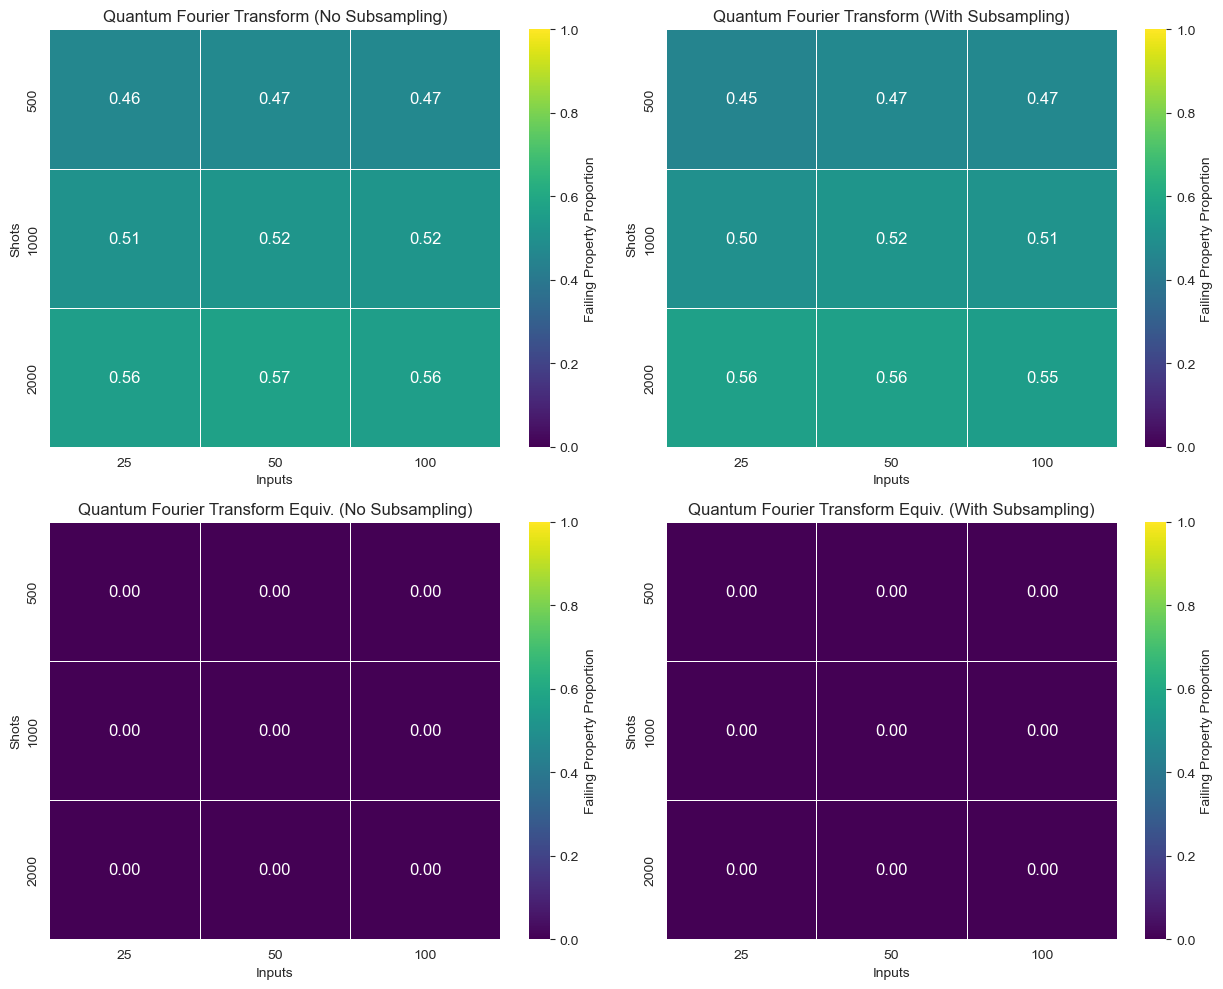

In [10]:
plot_percentage_failures(qft_df, "Quantum Fourier Transform")

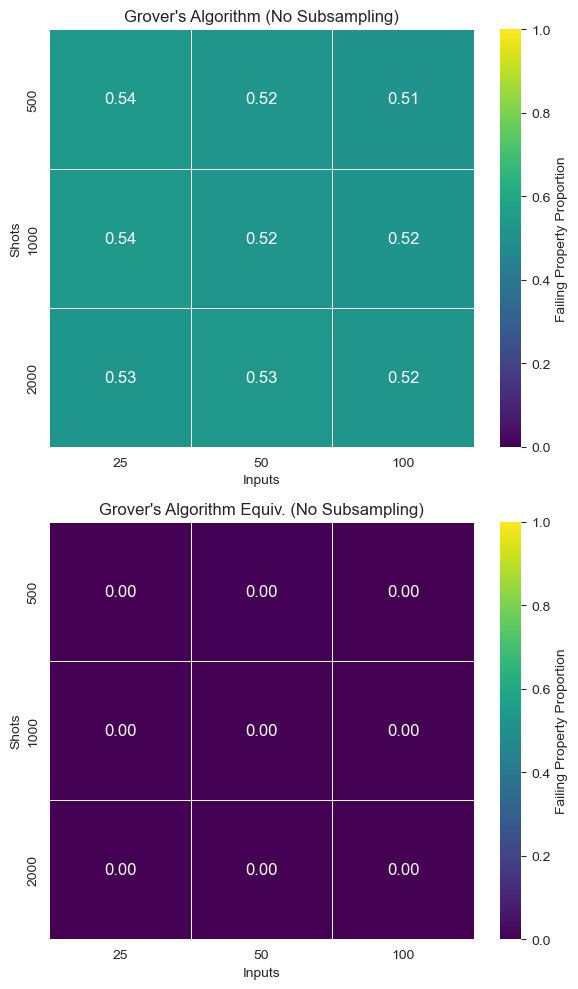

In [16]:
plot_percentage_failures(gr_df, "Grover's Algorithm", do_subsample=False)

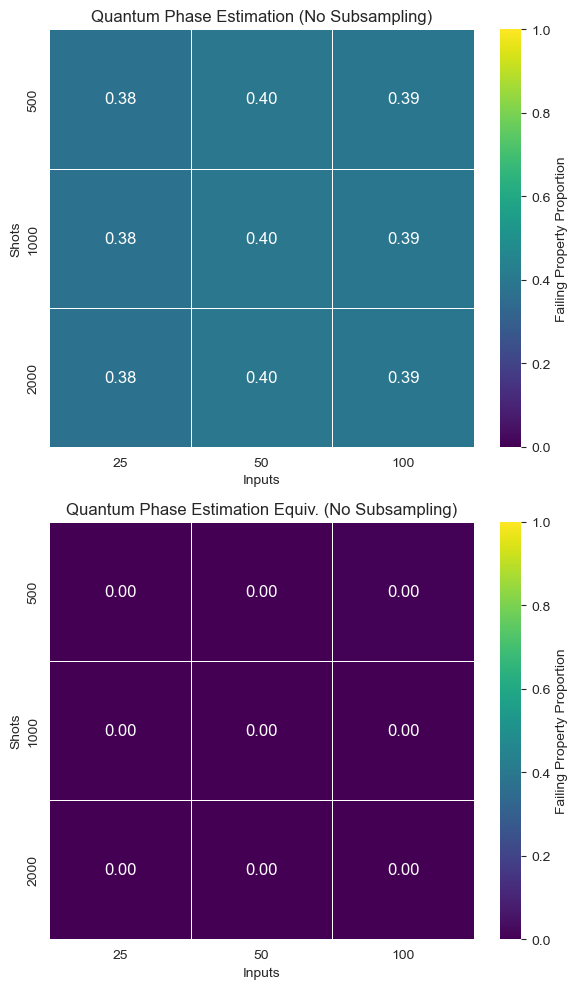

In [17]:
plot_percentage_failures(phase_df, "Quantum Phase Estimation", do_subsample=False)

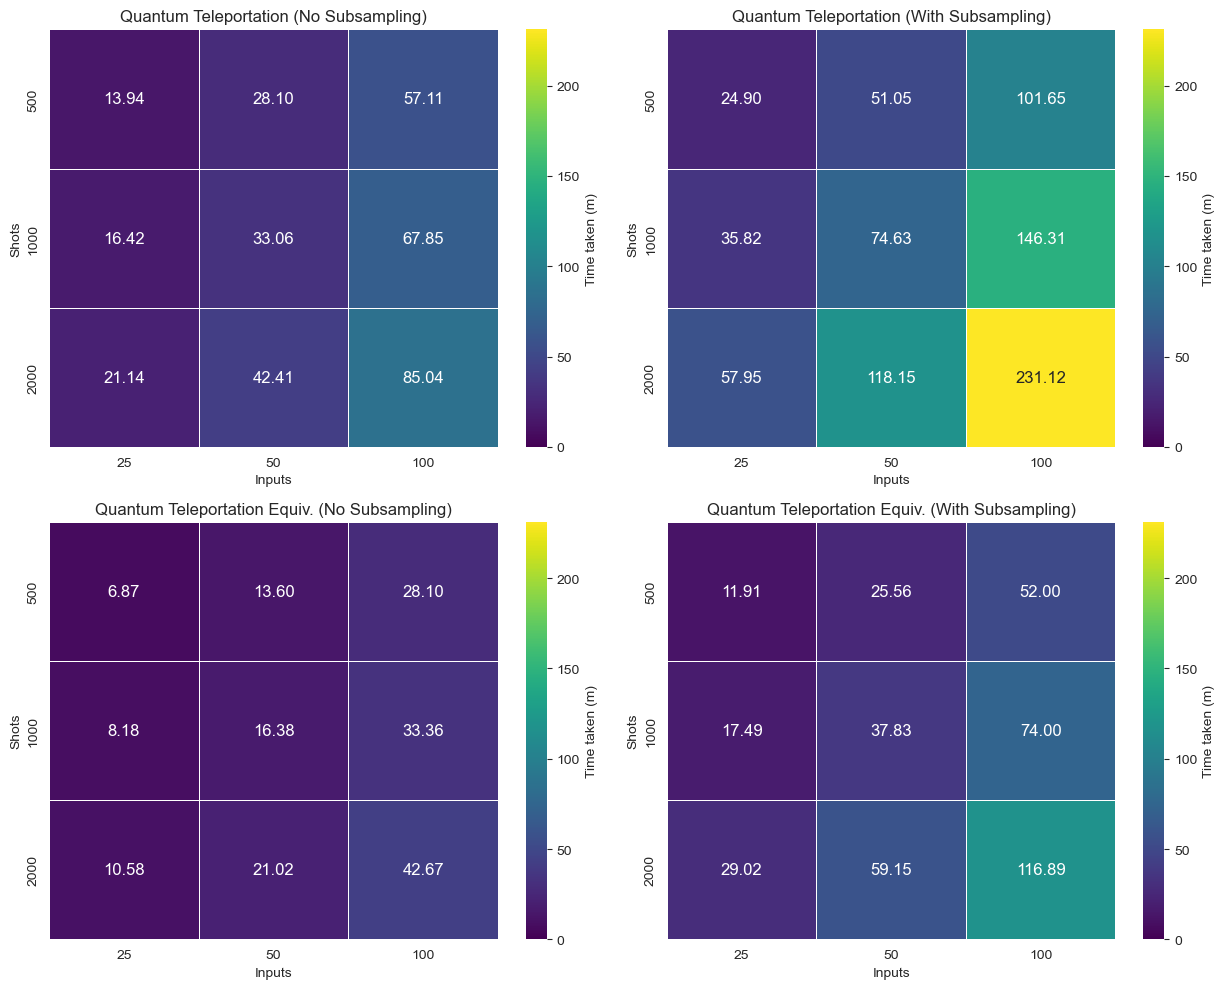

In [20]:
def plot_time_taken(df, algorithm_name, do_subsample=True):
    df_non_equivalent = df[df['mutant_name'].str.contains('_m')]
    df_equivalent = df[df['mutant_name'].str.contains('_em')]
    
    if do_subsample:
        df_non_equivalent_sub = df_non_equivalent[df_non_equivalent['subsample'] == True]
        df_equivalent_sub = df_equivalent[df_equivalent['subsample'] == True]
        failure_rate_sub = df_non_equivalent_sub.groupby(['shots', 'inputs'])['time'].apply(lambda x: x.sum()).unstack()
        pass_rate_sub = df_equivalent_sub.groupby(['shots', 'inputs'])['time'].apply(lambda x: x.sum()).unstack()
    
    df_non_equivalent_no_sub = df_non_equivalent[df_non_equivalent['subsample'] == False]
    df_equivalent_no_sub = df_equivalent[df_equivalent['subsample'] == False]
    failure_rate_no_sub = df_non_equivalent_no_sub.groupby(['shots', 'inputs'])['time'].apply(lambda x: x.sum()).unstack()
    pass_rate_no_sub = df_equivalent_no_sub.groupby(['shots', 'inputs'])['time'].apply(lambda x: x.sum()).unstack() 
    
    # Create subplots
    if do_subsample:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.5, 10))
        maximum_time = max(failure_rate_no_sub.max().max(), failure_rate_sub.max().max(), pass_rate_no_sub.max().max(), pass_rate_sub.max().max())   
    else:
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 10))
        maximum_time = max(failure_rate_no_sub.max().max(), pass_rate_no_sub.max().max()) 
        
    palette = sns.color_palette("viridis", as_cmap=True)

    # Plot heatmap for non-equivalent mutants without subsampling
    sns.heatmap(failure_rate_no_sub, annot=True, cmap=palette, ax=ax1, fmt='.2f', linewidth=0.5, vmin=0, vmax=maximum_time, cbar_kws={'label': 'Time taken (m)'}, annot_kws={"size": 12})
    ax1.set_title(f'{algorithm_name} (No Subsampling)')
    ax1.set_xlabel('Inputs')
    ax1.set_ylabel('Shots')

    # Plot heatmap for non-equivalent mutants with subsampling
    if do_subsample:
        sns.heatmap(failure_rate_sub, annot=True, cmap=palette, ax=ax2, fmt='.2f', linewidth=0.5, vmin=0, vmax=maximum_time, cbar_kws={'label': 'Time taken (m)'}, annot_kws={"size": 12})
        ax2.set_title(f'{algorithm_name} (With Subsampling)')
        ax2.set_xlabel('Inputs')
        ax2.set_ylabel('Shots')

    # Plot heatmap for equivalent mutants without subsampling
    sns.heatmap(pass_rate_no_sub, annot=True, cmap=palette, ax=ax3, fmt='.2f', linewidth=0.5, vmin=0, vmax=maximum_time, cbar_kws={'label': 'Time taken (m)'}, annot_kws={"size": 12})
    ax3.set_title(f'{algorithm_name} Equiv. (No Subsampling)')
    ax3.set_xlabel('Inputs')
    ax3.set_ylabel('Shots')

    # Plot heatmap for equivalent mutants with subsampling
    if do_subsample:
        sns.heatmap(pass_rate_sub, annot=True, cmap=palette, ax=ax4, fmt='.2f', linewidth=0.5, vmin=0, vmax=maximum_time, cbar_kws={'label': 'Time taken (m)'}, annot_kws={"size": 12})
        ax4.set_title(f'{algorithm_name} Equiv. (With Subsampling)')
        ax4.set_xlabel('Inputs')
        ax4.set_ylabel('Shots')

    plt.tight_layout()
    plt.show()
    
plot_time_taken(qt_df, "Quantum Teleportation", do_subsample=True)

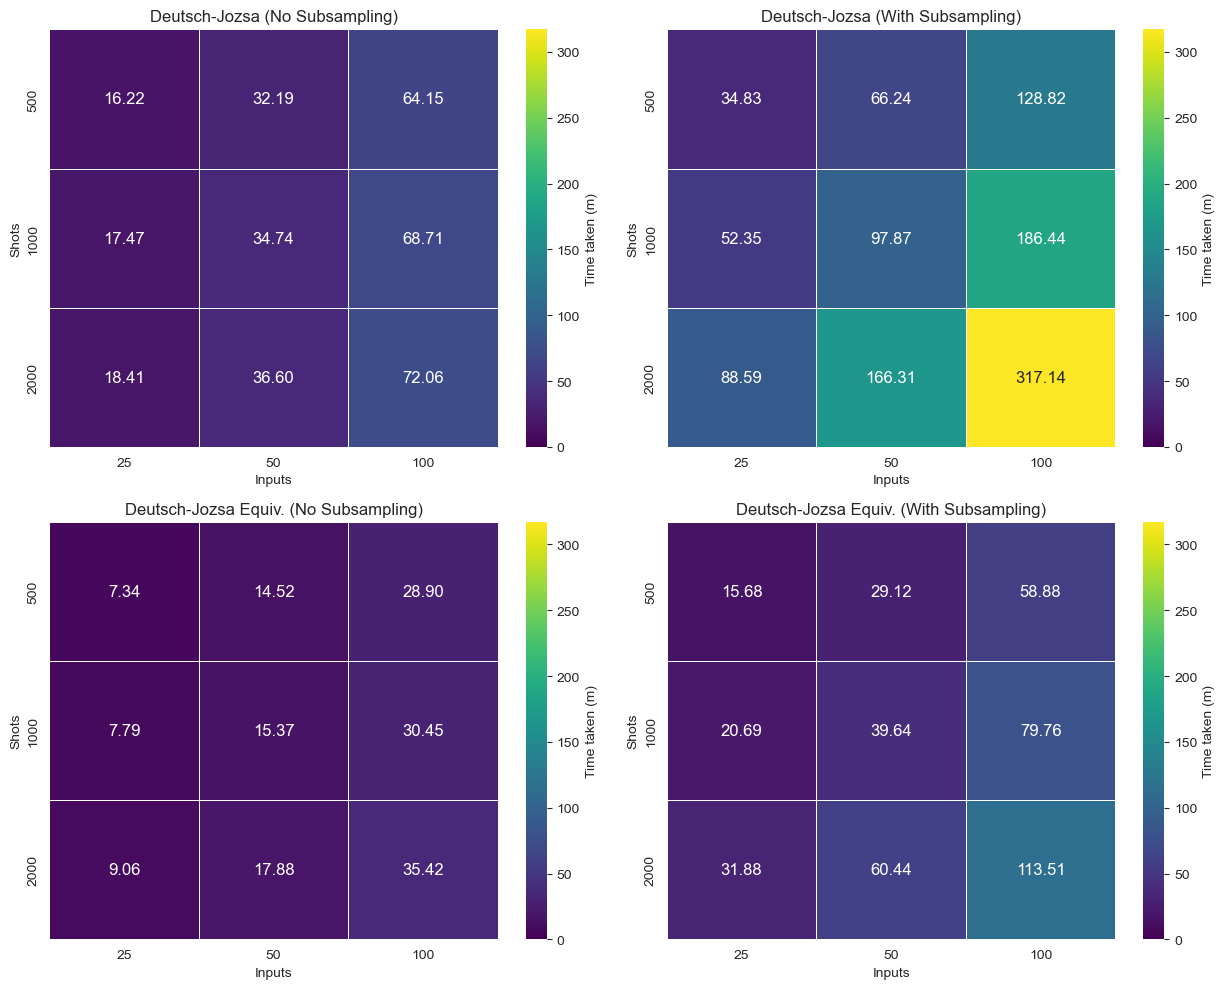

In [15]:
plot_time_taken(dj_df, "Deutsch-Jozsa")

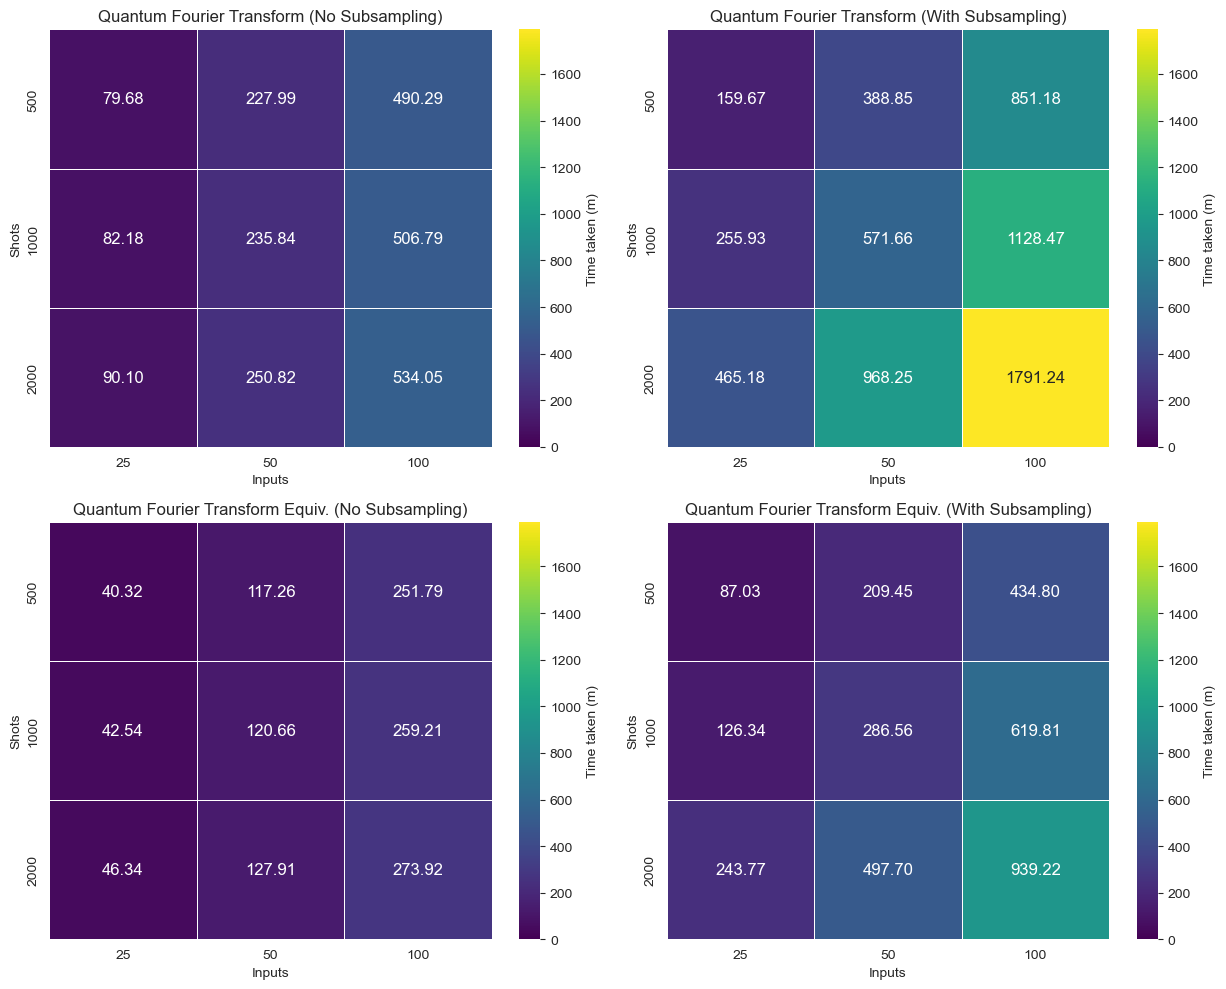

In [16]:
plot_time_taken(qft_df, "Quantum Fourier Transform")

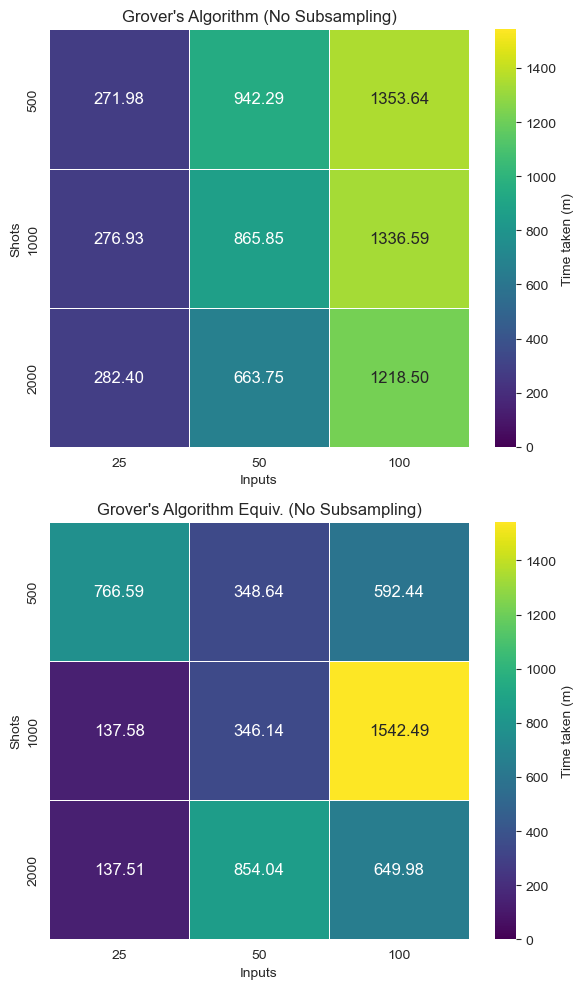

In [21]:
plot_time_taken(gr_df, "Grover's Algorithm", do_subsample=False)

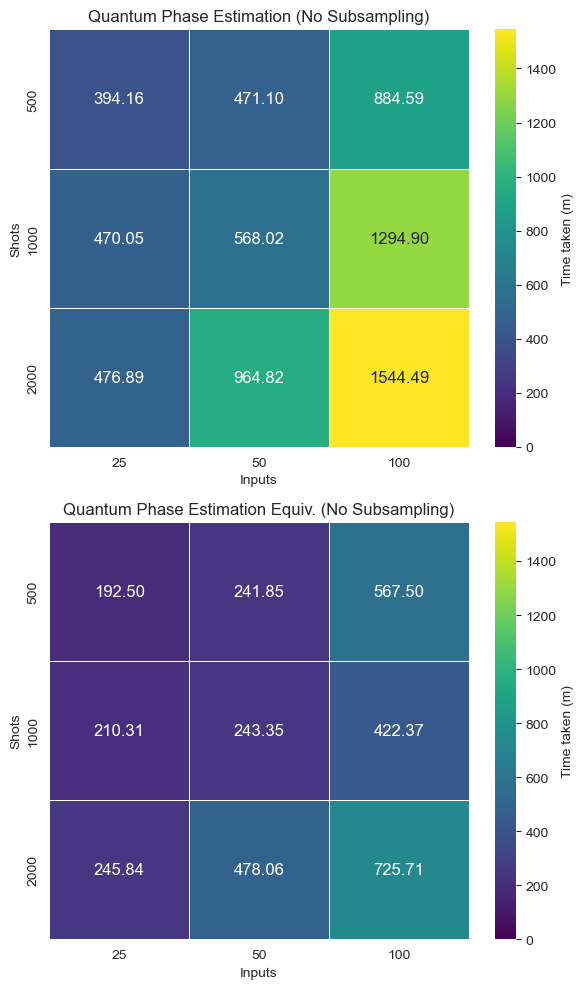

In [22]:
plot_time_taken(phase_df, "Quantum Phase Estimation", do_subsample=False)

In [19]:
def read_qs_data(algorithm_name):
    input = 25
    shots = 2000
    data_df = pd.DataFrame(columns=["mutant_name", "inputs", "shots", "result", "time"])
    filename_no_sub = f"mutation_test_results/{algorithm_name}/QS_{algorithm_name}_{input}_{shots}_mt_results.csv"
    with open(filename_no_sub, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        for i, line in enumerate(csvreader):
            if i != 0:
                data_df.loc[len(data_df.index)] = [line[0], input, shots, line[1], float(line[2])]
    return data_df

qs_qt_df = read_qs_data("quantum_teleportation")

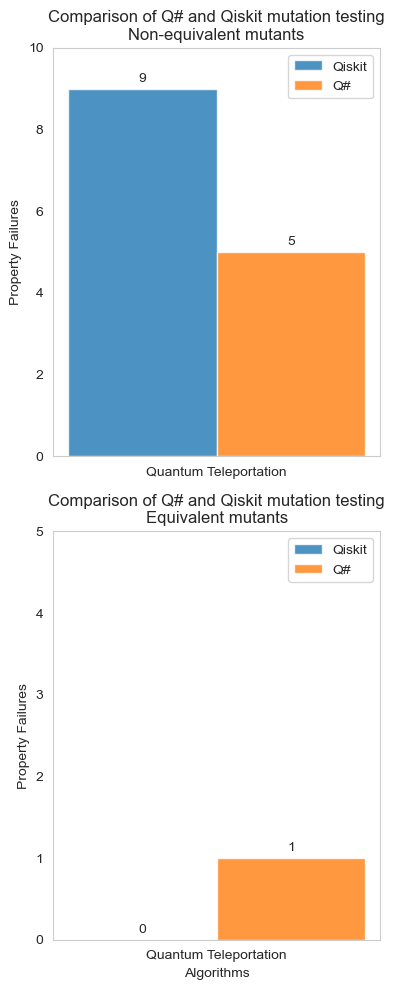

In [57]:
# plot the result for quantum teleportation, comparing QS and no QS
def plot_quantitative_analysis_comparison(feature_str):
    # get the number of failures for qs_qt_df
    qs_qt_df_non_equivalent = qs_qt_df[qs_qt_df['mutant_name'].str.contains('_m')]
    qs_non_equiv_failures = (qs_qt_df_non_equivalent["result"] == 'Fail').sum()
    
    qs_qt_df_equivalent = qs_qt_df[qs_qt_df['mutant_name'].str.contains('_em')]
    qs_equiv_failures = (qs_qt_df_equivalent["result"] == 'Fail').sum()
    
    # get the number of failures for qt_df
    qt_df_non_equivalent = qt_df[qt_df['mutant_name'].str.contains('_m')]
    qt_df_non_equivalent = qt_df_non_equivalent[qt_df_non_equivalent['shots'] == 2000]
    qt_df_non_equivalent = qt_df_non_equivalent[qt_df_non_equivalent['inputs'] == 25]
    qt_df_non_equivalent = qt_df_non_equivalent[qt_df_non_equivalent['subsample'] == False]
    qt_non_equiv_failures = (qt_df_non_equivalent[feature_str] == 'Fail').sum() 
    
    qt_df_equivalent = qt_df[qt_df['mutant_name'].str.contains('_em')]
    qt_df_equivalent = qt_df_equivalent[qt_df_equivalent['shots'] == 2000]
    qt_df_equivalent = qt_df_equivalent[qt_df_equivalent['inputs'] == 25]
    qt_df_equivalent = qt_df_equivalent[qt_df_equivalent['subsample'] == False]
    qt_equiv_failures = (qt_df_equivalent[feature_str] == 'Fail').sum() 

    algorithms = ["Quantum Teleportation"]
    
    algorithms_results_qiskit_non_equiv = np.array([qt_non_equiv_failures])
    algorithms_results_qs_non_equiv = np.array([qs_non_equiv_failures])
    algorithms_results_qiskit_equiv = np.array([qt_equiv_failures])
    algorithms_results_qs_equiv = np.array([qs_equiv_failures])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 10))
    width = 0.25
    
    # Define x-positions for the bars
    x = np.arange(len(algorithms))
    
    # Create the bars for non-equivalent mutants
    rects1 = ax1.bar(x - width/2, algorithms_results_qiskit_non_equiv, width, label='Qiskit', alpha=0.8)
    rects2 = ax1.bar(x + width/2, algorithms_results_qs_non_equiv, width, label='Q#', alpha=0.8)
    
    # Customize the plot for non-equivalent mutants
    ax1.set_ylabel('Property Failures')
    ax1.set_title('Comparison of Q# and Qiskit mutation testing\nNon-equivalent mutants')
    ax1.set_xticks(x)
    ax1.set_xticklabels(algorithms)
    ax1.legend()
    
    # Add value labels on the bars
    ax1.bar_label(rects1, padding=3)
    ax1.bar_label(rects2, padding=3)
    
    ax1.set_ylim(0, 10) 
    ax1.grid(False)
    
    # Create the bars for equivalent mutants
    rects3 = ax2.bar(x - width/2, algorithms_results_qiskit_equiv, width, label='Qiskit', alpha=0.8)
    rects4 = ax2.bar(x + width/2, algorithms_results_qs_equiv, width, label='Q#', alpha=0.8)
    
    # Customize the plot for equivalent mutants
    ax2.set_ylabel('Property Failures')
    ax2.set_xlabel('Algorithms')
    ax2.set_title('Comparison of Q# and Qiskit mutation testing\nEquivalent mutants')
    ax2.set_xticks(x)
    ax2.set_xticklabels(algorithms)
    ax2.legend()
    
    # Add value labels on the bars
    ax2.bar_label(rects3, padding=3)
    ax2.bar_label(rects4, padding=3)
    
    ax2.set_ylim(0, 5) 
    ax2.grid(False)
    
    # Adjust layout and display
    fig.tight_layout()
    plt.show()

# Call the function
plot_quantitative_analysis_comparison("result")

In [47]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import GlobalPhaseGate
from qiskit.quantum_info import Statevector
import numpy as np

In [51]:
qc = QuantumCircuit(1)
qc.rx(np.pi/2, 0)
qc.append(GlobalPhaseGate(np.pi/4), 0)
Statevector.from_instruction(qc)

Statevector([0.5+0.5j, 0.5-0.5j],
            dims=(2,))


In [44]:
qc = QuantumCircuit(1)
qc.sx(0)
Statevector.from_instruction(qc)


Statevector([0.5+0.5j, 0.5-0.5j],
            dims=(2,))
